In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy.stats import norm

In [166]:
calls = pd.read_csv("AAPL.csv")
calls['DTE+Date'] = calls['DTE'].astype(str) + " " + calls['QUOTE_DATE'].astype(str)
daysTillExp = calls['DTE+Date'].unique()
calls["iv"] = 0

In [167]:
calls

,ROW,QUOTE_DATE,UNDERLYING_LAST,EXPIRE_DATE,DTE,STRIKE,PRICE,DTE+Date,iv
0,0,2016-01-04,105.35,2016-01-08,0.010959,60.0,45.350000,0.010958904109589 2016-01-04,0
1,1,2016-01-04,105.35,2016-01-08,0.010959,65.0,40.355000,0.010958904109589 2016-01-04,0
2,2,2016-01-04,105.35,2016-01-08,0.010959,70.0,35.345000,0.010958904109589 2016-01-04,0
3,3,2016-01-04,105.35,2016-01-08,0.010959,75.0,30.355000,0.010958904109589 2016-01-04,0
4,4,2016-01-04,105.35,2016-01-08,0.010959,80.0,25.350000,0.010958904109589 2016-01-04,0
...,...,...,...,...,...,...,...,...,...
861774,22390,2020-12-31,132.60,2023-03-17,2.208110,180.0,14.855000,2.208109589041096 2020-12-31,0
861775,22391,2020-12-31,132.60,2023-03-17,2.208110,185.0,13.825001,2.208109589041096 2020-12-31,0
861776,22392,2020-12-31,132.60,2023-03-17,2.208110,190.0,12.725000,2.208109589041096 2020-12-31,0
861777,22393,2020-12-31,132.60,2023-03-17,2.208110,195.0,12.050000,2.208109589041096 2020-12-31,0


In [168]:
#
# S: Price Of Stock, K: Strike Price
# Sigma: Implied Volatility, t: years till expiration
# r: interest rate
#

#Theoretical Premium
def call_value(S, K, sigma, t=0, r=0):
    with np.errstate(divide='ignore'):
        d1 = np.divide(1, sigma * np.sqrt(t)) * (np.log(S/K) + (r+sigma**2 / 2) * t)
        d2 = d1 - sigma * np.sqrt(t)
    return np.multiply(norm.cdf(d1),S) - np.multiply(norm.cdf(d2), K * np.exp(-r * t))

#Calculates the gradient
def call_vega(S, K, sigma, t=0, r=0):
    with np.errstate(divide='ignore'):
        d1 = np.divide(1, sigma * np.sqrt(t)) * (np.log(S/K) + (r+sigma**2 / 2) * t)
    return np.multiply(S, norm.pdf(d1)) * np.sqrt(t)

#Uses Newton's method to find Implied volalility from theoretical premium
def bs_iv(price, S, K, t=0, r=0, precision=1e-4, initial_guess=5, itr=1000, verbose=False):
    iv = initial_guess
    for _ in range(itr):
        P = call_value(S, K, iv, t, r)
        diff = price - P
        if abs(diff) < precision:
            return iv
        grad = call_vega(S, K, iv, t, r)
        iv += diff/grad     
    if verbose:
        print(f"no convergence with {itr} iterations")
    return iv


In [169]:
pairs = calls.drop(columns=['UNDERLYING_LAST','PRICE'])
pairs.drop(columns=pairs.columns[0], 
        axis=1, 
        inplace=True)

In [170]:
pairs

,STRIKE,DTE+Date,iv
0,60.0,0.010958904109589 2016-01-04,0
1,65.0,0.010958904109589 2016-01-04,0
2,70.0,0.010958904109589 2016-01-04,0
3,75.0,0.010958904109589 2016-01-04,0
4,80.0,0.010958904109589 2016-01-04,0
...,...,...,...
861774,180.0,2.208109589041096 2020-12-31,0
861775,185.0,2.208109589041096 2020-12-31,0
861776,190.0,2.208109589041096 2020-12-31,0
861777,195.0,2.208109589041096 2020-12-31,0


In [172]:
count = 0
for index, row in calls.iterrows():
    count += 1
    pairs.iloc[index, 2] = bs_iv(row.PRICE, row.UNDERLYING_LAST, row.STRIKE, row.DTE, itr=500)
    if count == 300:
        break

C:\Users\pilug\AppData\Local\Temp/ipykernel_11432/250149363.py:29: RuntimeWarning: divide by zero encountered in double_scalars
  iv += diff/grad
C:\Users\pilug\AppData\Local\Temp/ipykernel_11432/250149363.py:10: RuntimeWarning: invalid value encountered in double_scalars
  d1 = np.divide(1, sigma * np.sqrt(t)) * (np.log(S/K) + (r+sigma**2 / 2) * t)
C:\Users\pilug\AppData\Local\Temp/ipykernel_11432/250149363.py:17: RuntimeWarning: invalid value encountered in double_scalars
  d1 = np.divide(1, sigma * np.sqrt(t)) * (np.log(S/K) + (r+sigma**2 / 2) * t)
C:\Users\pilug\AppData\Local\Temp/ipykernel_11432/250149363.py:10: RuntimeWarning: overflow encountered in double_scalars
  d1 = np.divide(1, sigma * np.sqrt(t)) * (np.log(S/K) + (r+sigma**2 / 2) * t)
C:\Users\pilug\AppData\Local\Temp/ipykernel_11432/250149363.py:17: RuntimeWarning: overflow encountered in double_scalars
  d1 = np.divide(1, sigma * np.sqrt(t)) * (np.log(S/K) + (r+sigma**2 / 2) * t)


In [173]:
pairs

,STRIKE,DTE+Date,iv
0,60.0,0.010958904109589 2016-01-04,1.325837
1,65.0,0.010958904109589 2016-01-04,1.536522
2,70.0,0.010958904109589 2016-01-04,NaN
3,75.0,0.010958904109589 2016-01-04,1.108555
4,80.0,0.010958904109589 2016-01-04,0.680834
...,...,...,...
861774,180.0,2.208109589041096 2020-12-31,0.000000
861775,185.0,2.208109589041096 2020-12-31,0.000000
861776,190.0,2.208109589041096 2020-12-31,0.000000
861777,195.0,2.208109589041096 2020-12-31,0.000000


In [207]:
calls_no_na = pairs.dropna()
calls_clean = calls_no_na[calls_no_na['iv']<0.6]

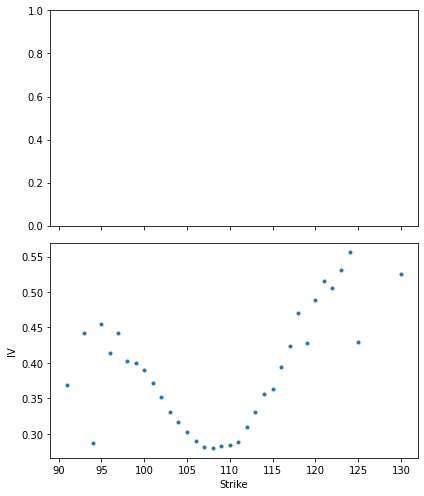

In [214]:
for day in daysTillExp[0:1]:
    calls_sub = calls_clean.loc[lambda calls_clean: calls_clean['DTE+Date'] == day]

    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(6,7), sharex=True)
    ax2.plot(calls_sub.STRIKE, calls_sub.iv, ".")
    ax2.set_ylabel("IV")
    ax2.set_xlabel("Strike")
    plt.tight_layout()
    # plt.savefig("calls_to_iv.png", dpi=400)
    plt.show()

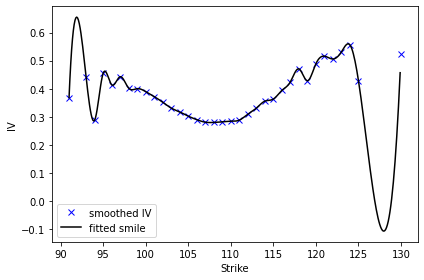

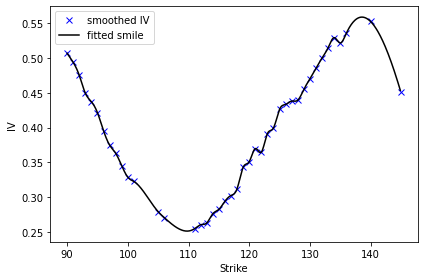

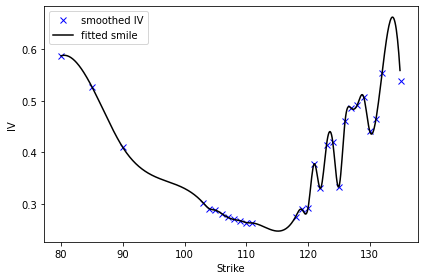

In [223]:
for day in daysTillExp[0:3]:

    calls_sub = calls_clean.loc[lambda calls_clean: calls_clean['DTE+Date'] == day]
    calls_sub["iv"] = scipy.ndimage.gaussian_filter1d(calls_clean.iv, 3)
    vol_surface = scipy.interpolate.interp1d(calls_sub.STRIKE, calls_sub.iv, kind="cubic",
                                 fill_value="extrapolate")
    x_new = np.arange(calls_sub.STRIKE.min(), calls_sub.STRIKE.max(), 0.1)
    plt.plot(calls_sub.STRIKE, calls_sub.iv, "bx", x_new, vol_surface(x_new), "k-");
    plt.legend(["smoothed IV", "fitted smile"], loc="best")
    plt.xlabel("Strike")
    plt.ylabel("IV")
    plt.tight_layout()
    # plt.savefig("SPY_smile.png", dpi=300)
    plt.show()

In [215]:
def pdf2():
    all_second_derivs = []
    for day in daysTillExp[0:1]:
        calls_sub = calls_clean.loc[lambda calls_clean: calls_clean['DTE+Date'] == day]

        vol_surface = scipy.interpolate.interp1d(calls_sub.STRIKE, calls_sub.iv, kind="cubic",
                                 fill_value="extrapolate")
                                 
        x_new = np.arange(calls_sub.STRIKE.min(), calls_sub.STRIKE.max(), 0.1)  

        Crange = call_value(calls.UNDERLYING_LAST[calls_sub.index[0]], x_new, vol_surface(x_new), calls.DTE[calls_sub.index[0]])
    
        first_deriv = np.gradient(Crange, x_new, edge_order=0)
        second_deriv = np.gradient(first_deriv, x_new, edge_order=0)

        all_second_derivs.append([x_new, second_deriv])
    
    return all_second_derivs

In [216]:
all_second_derivs = pdf2()

In [217]:
all_second_derivs[0][1]

array([ 1.57899758e-04,  1.65566206e-04,  1.77192692e-04,  1.93014188e-04,
        2.09266853e-04,  2.25870459e-04,  2.42739821e-04,  2.59785649e-04,
        2.76915408e-04,  2.94034202e-04,  3.11045635e-04,  3.27852661e-04,
        3.44358394e-04,  3.60466900e-04,  3.76083920e-04,  3.91117565e-04,
        4.05478940e-04,  4.19082721e-04,  4.31847669e-04,  4.43697085e-04,
        4.54559200e-04,  4.64367509e-04,  4.73061052e-04,  4.80584623e-04,
        4.86888941e-04,  4.91930761e-04,  4.95672942e-04,  4.98084461e-04,
        4.99140397e-04,  4.98821869e-04,  4.97115940e-04,  4.94015495e-04,
        4.89519091e-04,  4.83630773e-04,  4.76359878e-04,  4.67720822e-04,
        4.57732870e-04,  4.46419888e-04,  4.33810093e-04,  4.19935795e-04,
        4.04833127e-04,  3.88541780e-04,  3.71104733e-04,  3.52567985e-04,
        3.32980286e-04,  3.12392870e-04,  2.90859203e-04,  2.68434725e-04,
        2.45176599e-04,  2.21143473e-04,  1.96395247e-04,  1.70992848e-04,
        1.44998013e-04,  

In [218]:
for day in daysTillExp[0:5]:
        calls_sub = calls_no_na.loc[lambda calls_no_na: calls_no_na['DTE+Date'] == day]

        vol_surface = scipy.interpolate.interp1d(calls_sub.STRIKE, calls_sub.iv, kind="cubic",
                                 fill_value="extrapolate")
                                 
        x_new = np.arange(calls_sub.STRIKE.min(), calls_sub.STRIKE.max(), 0.1)  

        Crange = call_value(calls.UNDERLYING_LAST[calls_sub.index[0]], x_new, vol_surface(x_new), calls.DTE[calls_sub.index[0]])
    
        first_deriv = np.gradient(Crange, x_new, edge_order=0)
        second_deriv = np.gradient(first_deriv, x_new, edge_order=0)

        all_second_derivs.append(second_deriv)

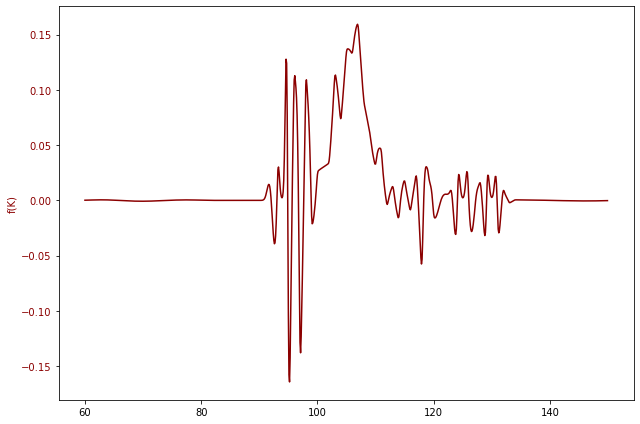

In [219]:
fig, ax1 = plt.subplots(figsize=(9,6))

col = 'darkred'
ax1.set_ylabel('f(K)', color=col)
ax1.plot(all_second_derivs[0][0], all_second_derivs[0][1], color=col)
ax1.tick_params(axis='y', labelcolor=col)

fig.tight_layout()
# plt.savefig("volspace_pdf.png", dpi=300)
plt.show()